In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [4]:
%cd ../../../11\ WS\ 2017-2018/Masterarbeit/Messungen/Calib_all_demo/messung/

/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Calib_all_demo/messung


In [6]:
messung = cv2.imread("Image__2018-06-28__13-20-34.png", 0)

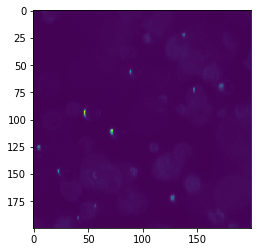

In [8]:
plt.imshow(messung[400:600, 400:600])